# bias studies with full systematics

To assess the impact of various sources of systematic, we will rely on an Asimov dataset.

In [1]:
## imports and configuration
%cd '/home/naodell/work/wbr/analysis'
%load_ext autoreload

from functools import partial
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from scipy.optimize import minimize
from tqdm import tqdm_notebook

import scripts.plot_tools as pt
import scripts.fit_helpers as fh
from nllfit.nllfitter import ScanParameters

np.set_printoptions(precision=3)
params = {
          'figure.figsize': (10, 10),
          'axes.labelsize': 20,
          'axes.facecolor': 'white',
          'axes.titlesize':'x-large',
          'legend.fontsize': 20,
          'xtick.labelsize':18,
          'ytick.labelsize':18,
          'font.size':18,
          'font.sans-serif':['Arial', 'sans-serif'],
          'mathtext.sf':'Arial',
          'lines.markersize':8.,
          'lines.linewidth':2.5,
         }
matplotlib.rcParams.update(params)

%connect_info

/home/naodell/work/wbr/analysis
{
  "shell_port": 45519,
  "iopub_port": 56113,
  "stdin_port": 50249,
  "control_port": 51515,
  "hb_port": 38001,
  "ip": "127.0.0.1",
  "key": "95c8a836-df4ab95f8a8207d15d723404",
  "transport": "tcp",
  "signature_scheme": "hmac-sha256",
  "kernel_name": ""
}

Paste the above JSON into a file, and connect with:
    $> jupyter <app> --existing <file>
or, if you are local, you can connect with just:
    $> jupyter <app> --existing kernel-50158135-2276-4fcb-92a3-68e495d1cbba.json
or even just:
    $> jupyter <app> --existing
if this is the most recent Jupyter kernel you have started.


In [2]:
# configure, get the input data, and do any additional processing that is needed
input_dir  = f'local_data/templates/test_new/'
selections = [
              'ee', 'emu', 'mumu',  
              'mutau', 'etau', 
              'mu4j', 'e4j'
             ]
processes = ['ttbar', 't', 'ww', 'wjets', 'zjets_alt', 'diboson', 'fakes'] 
n_selection = len(selections)
plot_labels = dict(
                   mumu  = [r'$\sf p_{T, \mu}$', r'$\mu\mu$'],
                   ee    = [r'$\sf p_{T, e}$', r'$ee$'],
                   emu   = [r'$\sf p_{T, \ell}$', r'$e\mu$'],
                   mutau = [r'$\sf p_{T, \tau}$', r'$\mu\tau$'],
                   etau  = [r'$\sf p_{T, \tau}$', r'$e\tau$'],
                   mu4j  = [r'$\sf p_{T, \mu}$', r'$\mu$ + jets'],
                   e4j   = [r'$\sf p_{T, e}$', r'$e$ + jets']
                  )

# initial values for W branching fraction (beta_e, beta_mu, beta_tau, beta_h) and tau branching fraction (b_e, b_mu, b_h)
br_tau_init = np.array([0.1783, 0.1741, 0.6476])
beta_init = np.array([0.108, 0.108, 0.108, 1 - 3*0.108]) 
var_beta  = [0.0009**2, 0.0009**2, 0.0009**2, 0.0031**2]

In [3]:
# initialize fit data
fit_data = fh.FitData(input_dir, selections, processes)

# build the process array
w_amp_init  = fh.signal_amplitudes(beta_init, br_tau_init, single_w=True)
ww_amp_init = fh.signal_amplitudes(beta_init, br_tau_init, single_w=False)
process_amplitudes = []
for process in processes:
    if process in ['zjets_alt', 'fakes', 'diboson']:
        process_amplitudes.append(1)
    elif process in ['ttbar', 't', 'ww']:
        process_amplitudes.extend(fh.signal_amplitudes(beta_init, br_tau_init)/ww_amp_init)
    elif process == 'wjets':
        process_amplitudes.extend(fh.signal_amplitudes(beta_init, br_tau_init, single_w=True)/w_amp_init)
        
process_amplitudes = np.array(process_amplitudes) 

In [4]:
# test the mixture
sel = 'mumu'
cat = 'cat_gt2_eq1_b'

# get the input data
model_data = fit_data.get_model_data(f'{sel}_{cat}')
model_tensor = model_data['model']

# build parameter array 
params = fit_data.get_params_init().values

# normalization params
norm_params = params[fit_data._npoi:fit_data._npoi + fit_data._nnorm]
norm_params = model_data['norm_matrix']*norm_params
norm_params[norm_params == 0] = 1

# shape params
shape_params_masked = params[fit_data._npoi + fit_data._nnorm:]
shape_params_masked = shape_params_masked[model_data['shape_param_mask']]
shape_params_masked = np.concatenate([[1, 0], 0.5*shape_params_masked**2, 0.5*shape_params_masked])

# mask amplitudes and propagate normalization n.p.
process_amplitudes_masked = process_amplitudes[model_data['process_mask']]
process_amplitudes_masked = norm_params.T*process_amplitudes_masked
process_amplitudes_masked = np.product(process_amplitudes_masked, axis=0)

# build expectation from model_tensor
expected_pre = np.tensordot(model_tensor[:,:,0].T, process_amplitudes_masked, axes=1) # mixture model
expected_var = np.tensordot(model_tensor[:,:,1].T, process_amplitudes_masked, axes=1) # mixture model

#expected_post = np.tensordot(model_tensor, shape_params_masked, axes=1) # n.p. modification
#expected_post = np.tensordot(expected_post.T, process_amplitudes_masked, axes=1) 
params = fit_data.get_params_init().copy()
#params['lumi'] -= 0.025
#params['trigger_e'] -= 0.01
#params['trigger_mu'] -= 0.005
params['top_pt'] += 1.
params = params.values
expected_post, _ = fit_data.mixture_model(params, f'{sel}_{cat}')

# get the data and binning
template_data = fit_data.get_selection_data(sel)[cat]
data_val, data_var = template_data['templates']['data']['val'], template_data['templates']['data']['var']
bins = template_data['bins'][:-1]
dx = (bins[1:] - bins[:-1])
dx = np.append(dx, dx[-1]) 
x  = bins + dx/2         

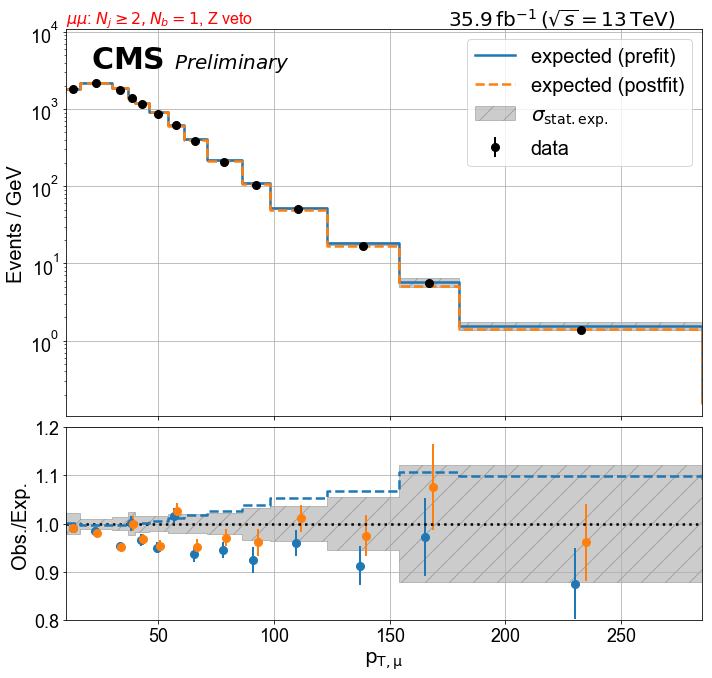

In [5]:
# overlay expectation with target values

fig, axes = plt.subplots(2, 1, figsize=(10, 10), facecolor='white', sharex=True, gridspec_kw={'height_ratios':[2,1]})
#fig.subplots_adjust(hspace=0) # doesn't work with tight layout

ax = axes[0]
ax.errorbar(x, data_val/dx, np.sqrt(data_val)/dx, fmt='ko', capsize=0, elinewidth=2, label='data')
ax.plot(bins, expected_pre/dx, drawstyle='steps-post', c='C0', linestyle='-', label='expected (prefit)')
ax.plot(bins, expected_post/dx, drawstyle='steps-post', c='C1', linestyle='--', label='expected (postfit)')
ax.fill_between(bins, (expected_pre - np.sqrt(expected_var))/dx, (expected_pre + np.sqrt(expected_var))/dx, color='k', step='post', hatch='/', alpha=0.2, label=r'$\sigma_{\sf stat. exp.}$')
ax.set_ylim(np.min(data_val/dx), 5.*np.max(data_val/dx))
ax.set_yscale('log')
ax.set_ylabel('Events / GeV')
ax.set_title(f'{plot_labels[sel][1]}: {pt.categories[cat].label}', fontsize=16, loc='left', color='red')
pt.add_lumi_text(ax, 35.9)
ax.legend()
ax.grid()

ax = axes[1]
ax.plot(bins[[0,-1]], [1, 1], 'k:')

ax.errorbar(x*(1-0.01), data_val/expected_pre, np.sqrt(data_val)/expected_pre, fmt='C0o', capsize=0, elinewidth=2, label='prefit')
ax.errorbar(x*(1+0.01), data_val/expected_post, np.sqrt(data_val)/expected_post, fmt='C1o', capsize=0, elinewidth=2, label='postfit')
ax.plot(bins, expected_pre/expected_post, drawstyle='steps-post', c='C0', linestyle='--', label='prefit/postfit')

ax.fill_between(bins, 1-np.sqrt(expected_var)/expected_pre, 1+np.sqrt(expected_var)/expected_pre, color='k', step='post', hatch='/', alpha=0.2, label='expected_var')
ax.set_xlim(x[0]-dx[0]/2, x[-2]+dx[-2]/2)
ax.set_ylim(0.8, 1.2)
ax.set_ylabel('Obs./Exp.')
ax.set_xlabel(plot_labels[sel][0])
#ax.legend()
ax.grid()

plt.tight_layout(h_pad=0., rect=[0., 0., 1., 0.95])
plt.savefig(f'plots/fits/{sel}_{cat}.png')
plt.show()